In [7]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from tqdm import trange

def simulate_auction(tau, omega, psi, sigma):
    """
    This function simulates the liquidity risk n_simulations times for every timestep tau
    and average the results.
    """
    K = 1+np.random.poisson(omega*tau)
    traders_arrival_times = 1/omega*np.arange(1,K+1)
    unobservable_price = np.cumsum(np.random.normal(0,psi/np.sqrt(omega),K))
    reservation_prices = unobservable_price + np.random.normal(0, sigma, K)
    clearing_price = np.mean(reservation_prices)
    return clearing_price

# PARAMETERS
omega = 30
psi = 2
sigma = 1
tau = omega/(psi*np.sqrt(omega))


## Step 1 - Simulate a large number of auctions
n_auctions = 1000
historical_prices = [simulate_auction(tau, omega, psi, sigma) for i in range(n_auctions)]

## Step 2 - Compute quantiles
alpha = 0.05
low_quantile = np.quantile(historical_prices, alpha)
high_quantile = np.quantile(historical_prices, 1-alpha)

## Step 3 - Buy and sell when clearing price quantile is high or low, and update distitribution/quantiles at every new auction [or rolling window]
next_auctions = 101
Q = 10
V = 5 #elasticity price volume
realized_PnL = []
asset_inventory = []

sell_flag, buy_flag = 0,0
for i in range(next_auctions):
    K = 1+np.random.poisson(omega*tau)
    traders_arrival_times = 1/omega*np.arange(1,K+1)
    unobservable_price = np.cumsum(np.random.normal(0,psi/np.sqrt(omega),K))
    reservation_prices = unobservable_price + np.random.normal(0, sigma, K)
    clearing_price = np.mean(reservation_prices) #observed price before the end of the auction
   # historical_prices.append(clearing_price)
   # low_quantile = np.quantile(historical_prices, alpha)
   # high_quantile = np.quantile(historical_prices, 1-alpha)

    if (sell_flag != 0):
        clearing_price = Q/(V*K)+clearing_price
        realized_PnL.append(Q*(sell_flag - clearing_price))
        asset_inventory.append(-Q)
        sell_flag = 0
        pass

    elif (buy_flag != 0):
        clearing_price = -Q/(V*K)+clearing_price
        realized_PnL.append(Q*(clearing_price - buy_flag))
        asset_inventory.append(Q)
        buy_flag = 0
        pass

    elif (clearing_price < low_quantile) and (buy_flag == 0) and (sell_flag == 0): #we buy at this auction and we sell at the next one
        clearing_price = -Q/(V*K)+clearing_price
        buy_flag = clearing_price #keep the price in memory to update PnL at next auction
        asset_inventory.append(Q)
        realized_PnL.append(0)
        pass
        
    elif (clearing_price > high_quantile) and (buy_flag == 0) and (sell_flag == 0): #we sell at this auction and we buy at the next one
        clearing_price = Q/(V*K)+clearing_price
        sell_flag = clearing_price
        asset_inventory.append(-Q)
        realized_PnL.append(0)
        pass

    else:
        asset_inventory.append(0)
        realized_PnL.append(0)


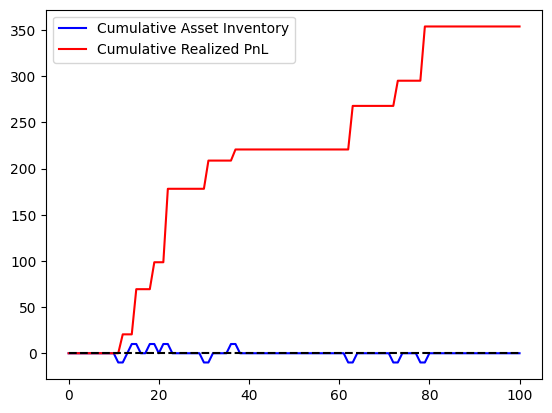

In [8]:
plt.plot(range(next_auctions), asset_inventory, 'b', label = 'Cumulative Asset Inventory')
plt.plot(range(next_auctions), np.cumsum(realized_PnL),'r', label = 'Cumulative Realized PnL')
plt.plot(range(next_auctions), [0]*next_auctions, 'k--')
plt.legend(loc = 'best')